In [1]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 21.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.2 MB 14.9 MB/s eta 0:00:01
     |████████████████████████████████| 7.8 MB 96.7 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 32.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 20.0 MB/s eta 0:00:01
     |████████████████████████████████| 244 kB 14.6 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 60.4 MB/s eta 0:00:01
     |████████████████████████████████| 505 kB 58.6 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 50.3 MB/s eta 0:00:01
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to resta

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
import numpy as np

In [4]:
file_path = r"/Users/anjanapro/Desktop/machine learning/flight_delay_prediction/notebooks/merged_data_with_labels.csv"
df = pd.read_csv(file_path)

classifier_columns = ["windspeedKmph", "winddirDegree", "precipMM", "visibility", "pressure", 
                      "cloudcover", "DewPointF", "WindGustKmph", "tempF", "WindChillF", "humidity", "DepDelayMinutes"]

# read the file from a filepath to its csv into a dataframe
file_path_train = r"/Users/anjanapro/Desktop/machine learning/flight_delay_prediction/notebooks/clf_train_data.csv"
file_path_test = r"/Users/anjanapro/Desktop/machine learning/flight_delay_prediction/notebooks/clf_test_data.csv"
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

# assuming 'ArrDel15' is the target variable
X_train = df_train.drop('ArrDel15', axis=1) 
y_train = df_train['ArrDel15']  

X_test = df_test.drop('ArrDel15', axis=1) 
y_test = df_test['ArrDel15']  


# based on how the testing set for classification and regression is the same based on how it was structured for resampling...
# all we need is the corresponding Ddelays which is in the "ArrDelayMinutes" column of the reg_test_data, where the X_test is the same for both 
# classificationa and regression
file_path_test_reg = r"/Users/anjanapro/Desktop/machine learning/flight_delay_prediction/notebooks/reg_test_data.csv"
df_test_reg = pd.read_csv(file_path_test_reg)
X_test_reg = df_test_reg.drop('ArrDelayMinutes', axis=1) 
y_test_reg = df_test_reg['ArrDelayMinutes']  

In [5]:
# train best-performing classifier as chosen by the highest F1-score among the classifiers (Decision Tree Classifier)
classifier = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=8, min_samples_leaf=5)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=42)

In [6]:
y_pred_clf = classifier.predict(X_test)

In [7]:
# create a filtered dataset of the original dataset that contains only information about delayed flights to train regressors on
delayed_flights = df[df["ArrDel15"] == 1]

In [8]:
X_train_delayed, X_test_delayed, y_train_delayed, y_test_delayed = train_test_split(delayed_flights[classifier_columns], delayed_flights["ArrDelayMinutes"], test_size=0.2, random_state=42)

In [9]:
# train different regressors to see which performs the best in a pipeline with the chosen classifier

# XGBoost Regressor trained on only delayed flight information
xgregressor = GradientBoostingRegressor()
xgregressor.fit(X_train_delayed, y_train_delayed)

GradientBoostingRegressor()

In [10]:
# Extra Trees Regressor trained on only delayed flight information
et_regressor = ExtraTreesRegressor()
et_regressor.fit(X_train_delayed, y_train_delayed)

ExtraTreesRegressor()

In [11]:
# Random Forest Regressor trained on only delayed flight information
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_delayed, y_train_delayed)

RandomForestRegressor()

In [12]:
# Linear Regressor trained on only deayed flight information
ln_regressor = LinearRegression()
ln_regressor.fit(X_train_delayed, y_train_delayed)

LinearRegression()

In [13]:
# filter the prediction output of the classifier to only consist of the corresponging X_test feature values 
# and Delay Minutes of the predicted delayed flights
df_reg_X_test = X_test[y_pred_clf == 1]
df_reg_y_test = y_test_reg[y_pred_clf == 1]


In [14]:
# move DepDelayMinutes to the back to match the order in which features were fitted in the moddle
depDelay = df_reg_X_test["DepDelayMinutes"]

df_reg_X_test= df_reg_X_test.drop('DepDelayMinutes', axis=1) 


In [15]:
df_reg_X_test = pd.concat([df_reg_X_test, depDelay], axis=1)

In [16]:
# prediction of the pipeline with the XG Boost Regressor
y_pred_xg = xgregressor.predict(df_reg_X_test)


In [17]:
# prediction of the pipeline with the Linear Regressor
y_pred_ln = ln_regressor.predict(df_reg_X_test)

In [18]:
# prediction of the pipeline with the Random Forest Regressor
y_pred_rf = rf_regressor.predict(df_reg_X_test)

In [19]:
# prediction of the pipeline with the Extra Trees Regressor
y_pred_et = et_regressor.predict(df_reg_X_test)

In [108]:
import os
import csv

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score


def evaluate_and_save_classification_results(model_name, y_test, y_pred, output_file="pipeline_results.csv"):
    report = {}
    # calculate MSE; the average squared difference between predicted and actual values
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    # calculate the RMSE; the square root of MSE
    # easier to interpret in the same units as the target variable (delay duration in minutes).
    rmse = np.sqrt(mse)

    # calculate R-squared
    # proportion of variance in target variable given by model
    # ranges from 0 to 1, with higher values indicating a better fit
    r2 = r2_score(y_test, y_pred)

    metrics = {
        'Model': [model_name],
        'MAE': [mae],
        'MSE': [mse],
        'RMSE': [rmse],
        'R-squared': [r2]
    }
    
    # convert to dataframe
    metrics_df = pd.DataFrame(metrics)
    
    # append to csv file
    if not os.path.isfile(output_file):
        metrics_df.to_csv(output_file, index=False)
    else:
        metrics_df.to_csv(output_file, mode='a', header=False, index=False)


evaluate_and_save_classification_results("Extra Trees Regression Pipeline", df_reg_y_test, y_pred_et)
evaluate_and_save_classification_results("Random Forest Regression Pipeline", df_reg_y_test, y_pred_rf)
evaluate_and_save_classification_results("Linear Regression Pipeline", df_reg_y_test, y_pred_ln)
evaluate_and_save_classification_results("XGBoost Regressive Pipeline", df_reg_y_test, y_pred_xg)

In [112]:
max_delay = max(y_pred_et)
print("Maximum delay in y_pred_et:", max_delay)

Maximum delay in y_pred_et: 2142.0


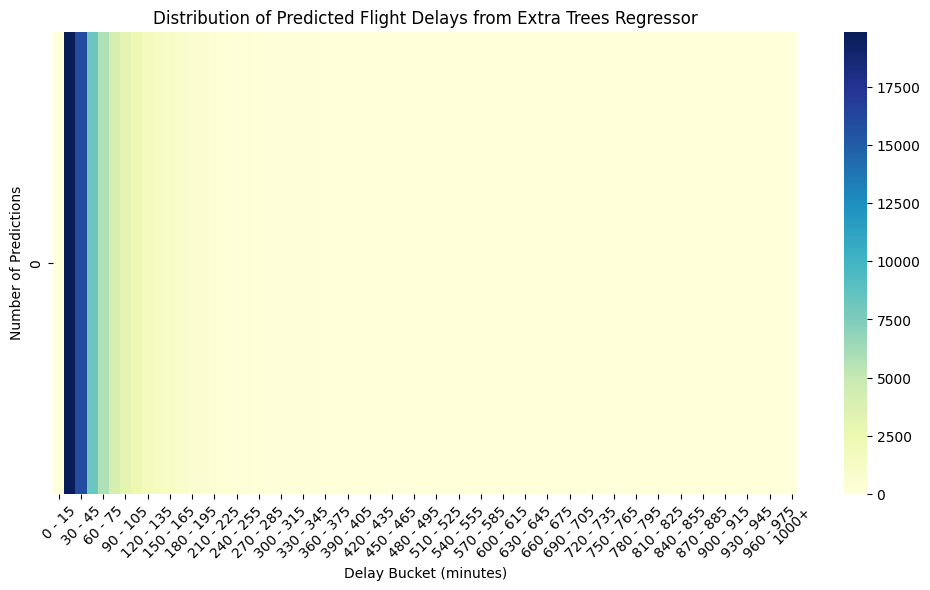

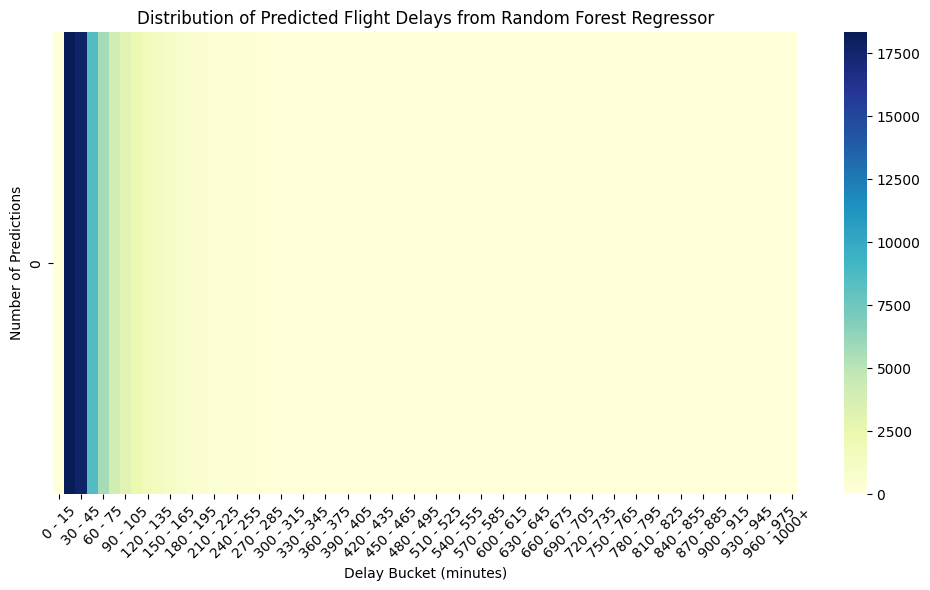

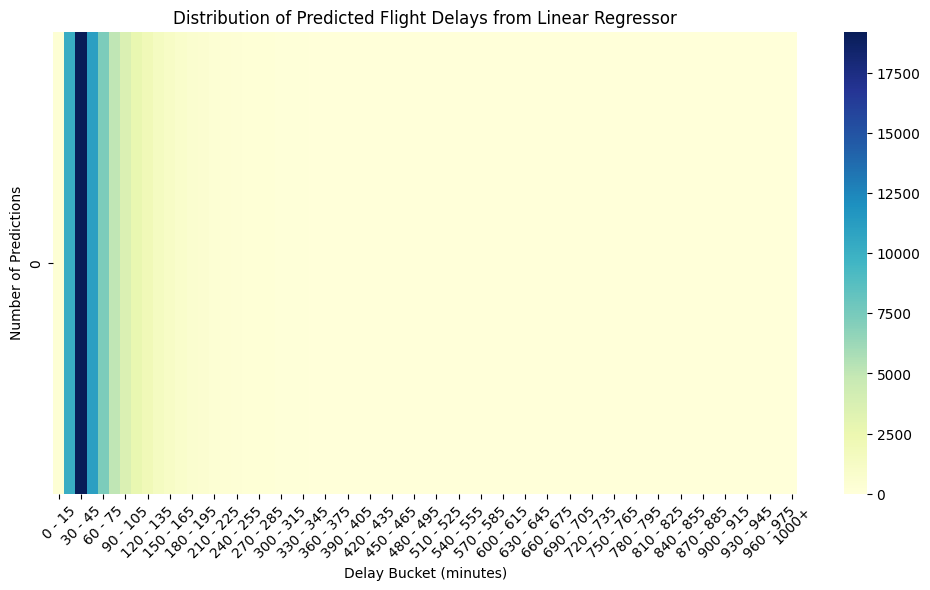

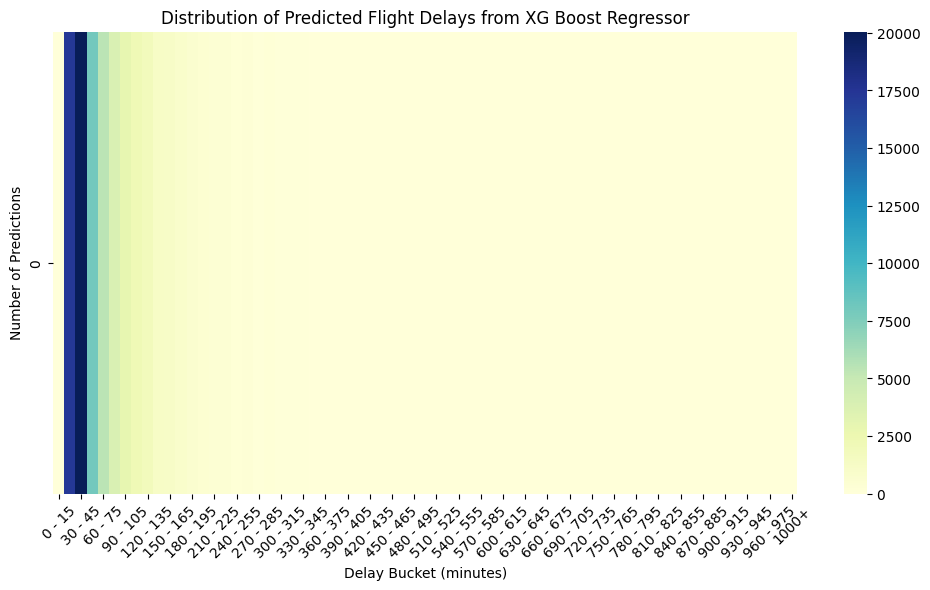

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_delay_heatmap(y_pred, title, num_buckets=66, bucket_width=15):
  # count delays within regular buckets and a separate bucket for very high delays
  delay_buckets = [0] * (num_buckets + 1)  
  for delay in y_pred:
    if delay > 1000:
      delay_buckets[-1] += 1 
    else:
      bucket_index = int(delay // bucket_width)
      delay_buckets[bucket_index] += 1

  # create labels for all buckets 
  bucket_labels = [f"{b * bucket_width} - {(b+1) * bucket_width}" for b in range(num_buckets)] + ["1000+"]

  # create a dataframe from the bucket counts
  delay_df = pd.DataFrame(data=[delay_buckets], columns=bucket_labels)

  # generate the heatmap
  fig, ax = plt.subplots(figsize=(12, 6))
  sns.heatmap(delay_df, cmap='YlGnBu', ax=ax)

  # set labels and title for the axes
  ax.set_xlabel("Delay Bucket (minutes)")
  ax.set_ylabel("Number of Predictions")
  ax.set_title(title)


  plt.xticks(rotation=45)
  plt.show()


plot_delay_heatmap(y_pred_et, "Distribution of Predicted Flight Delays from Extra Trees Regressor")
plot_delay_heatmap(y_pred_rf, "Distribution of Predicted Flight Delays from Random Forest Regressor")
plot_delay_heatmap(y_pred_ln, "Distribution of Predicted Flight Delays from Linear Regressor")
plot_delay_heatmap(y_pred_xg, "Distribution of Predicted Flight Delays from XG Boost Regressor")


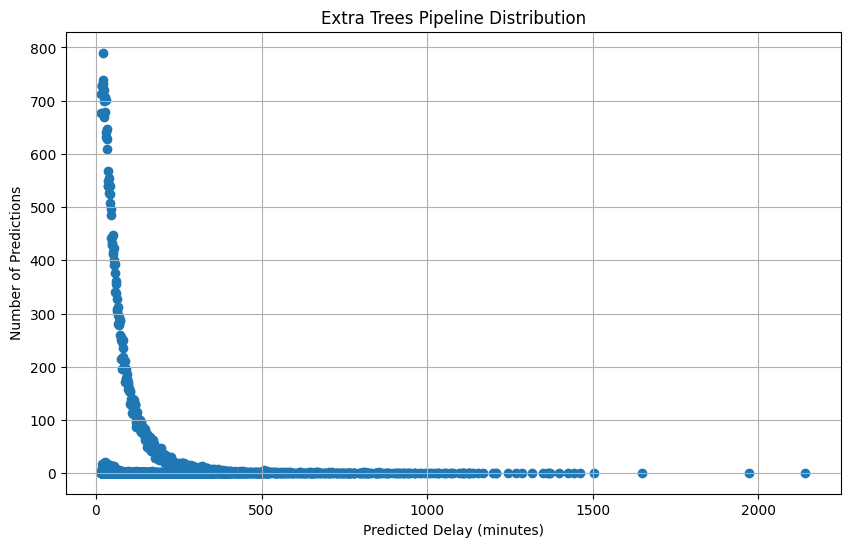

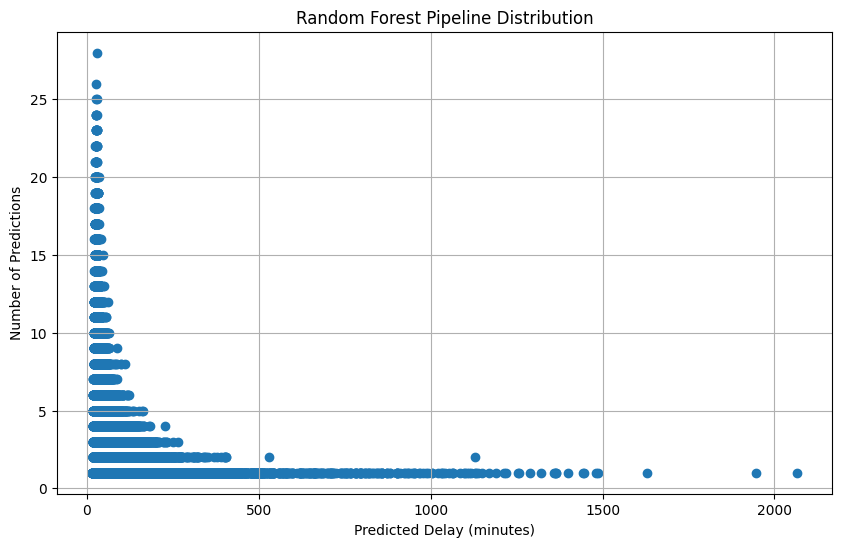

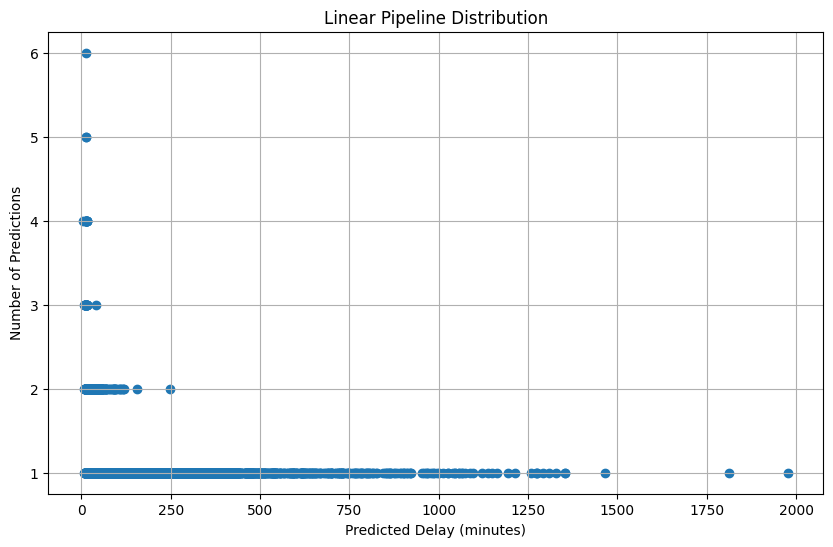

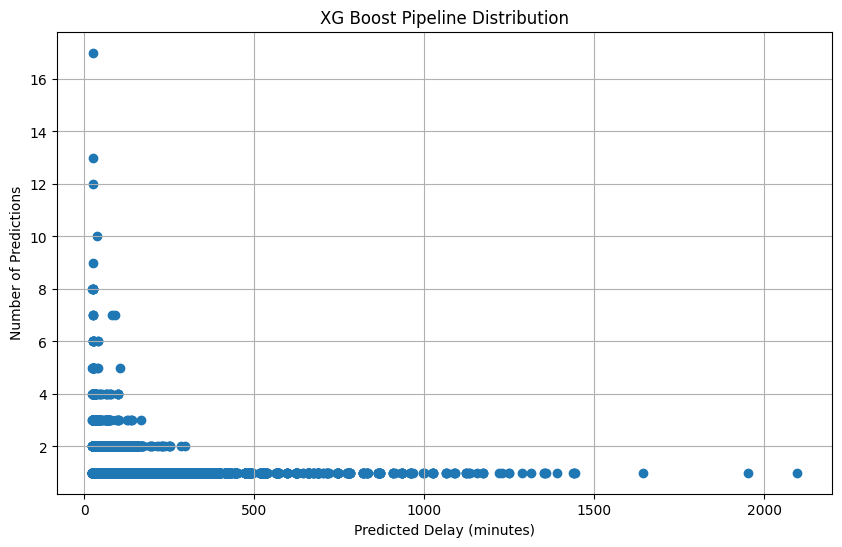

In [120]:
def plot_delay_scatter(y_pred, title):
  delay_counts = {}
  for delay in y_pred:
    if delay in delay_counts:
      delay_counts[delay] += 1
    else:
      delay_counts[delay] = 1

  delays = sorted(delay_counts.keys())
  counts = [delay_counts[delay] for delay in delays]

  plt.figure(figsize=(10, 6))
  plt.scatter(delays, counts)
  plt.xlabel("Predicted Delay (minutes)")
  plt.ylabel("Number of Predictions")
  plt.title(title)
  plt.grid(True)
  plt.show()

plot_delay_scatter(y_pred_et, "Extra Trees Pipeline Distribution")
plot_delay_scatter(y_pred_rf, "Random Forest Pipeline Distribution")
plot_delay_scatter(y_pred_ln, "Linear Pipeline Distribution")
plot_delay_scatter(y_pred_xg, "XG Boost Pipeline Distribution")
